## PyQuake3D Usage Tutorial

This Jupyter Notebook provides a step-by-step guide to installing and using **PyQuake3D**, a Python-based Boundary Element Method (BEM) tool for 3D earthquake sequence simulations with seismic and aseismic slip. We'll cover installation, compilation, setup, and running a simple simulation.

**Features:**
- 3D non-planar quasi-dynamic earthquake cycle simulations
- Support for rate-and-state aging friction laws
- Support for Hierarchical matrix storage and calculation
- Support for GPU acceleration via CuPy
- MPI acceleration support
- Suitable for large model earthquake cycle simulation
- Support for pore fluid pressure varing with slip due to inelastic processes including dilatancy, pore compaction

**Note:** MPI simulations may not run seamlessly in Jupyter due to their multi-process nature. We will first show how to install the simplest single-CPU version, then how to install the GPU driver, cupy, and how to run MPI-accelerated PyQuake3D on Linux system.

## Step 1: Set Up Conda environment

1. Download from https://www.anaconda.com/docs/getting-started/miniconda/install
2. Then install it using exe program.
3. Open miniconda Prompt and navigate to the working directory(e.g. E:\work) using:
E:
then
cd E:\work

3. After installation, create a new environment:
conda create -n PyQuake3D python=3.12
4. Activate the environment:
conda activate PyQuake3D
5. Install Jupyter notebook using: conda install jupyter notebook





## Step 2: Install Python Dependencies

**For single GPU/CPU verison**
1. Download from https://github.com/Computational-Geophysics/PyQuake3D

2. Install PyQuake3D using pip:

   *pip install -r requirements.txt*

   or

   *python -m pip install -r requirements.txt*

   (make sure PyQuake3D environment is activated)

**Notes**:PyQuake3D supports Python 3.8 and above, so there is no need to specify a specific version when installing the library.


## Step 3: Runging a simple case (For single GPU/CPU verison).
The easiest way to run pyquake3d is to run the single CPU version of Pyquake3D, without installing cupy.

1. Read model and mesh parameter(Please refer to mannul for specific meanning).
2. Calculating Green functions.
3. Calculating Qusi-Dynamic model.
4. Visualize the results.

You can also run the BP5-QD example case in the terminal:

python src/main_mpi.py -g examples/BP5-QD/bp5t.msh -p examples/BP5-QD/parameter.txt

## Initial: Import all sub-functions and libraries


In [1]:
#Let runing PyQuake3D
#First Import all sub-functions

import readmsh
import numpy as np
import sys
import matplotlib.pyplot as plt
import QDsim_gpu
from math import *
import time
import argparse
import os
import psutil
from datetime import datetime
process = psutil.Process(os.getpid())



## Step 1: read the model file, parameter file, and create a basic class
We prepared the msh file and parameter.txt

In [2]:


fnamegeo='BP5_3k/bp5t.msh'
fnamePara='BP5_3k/parameter.txt'
nodelst,elelst=readmsh.read_mshV2(fnamegeo)



## Step 2:  calculate greenfunctions,we encapsulate all calculations in a class QDsim
The Green function calculation is saved in the Corefunc directory defined in parameter.txt. The next time you start the program, you no longer need to calculate the Green function.

In [7]:
#Then it start to calculate greenfunctions,We encapsulate all calculations in a class QDsim
sim0=QDsim_gpu.QDsim(elelst,nodelst,fnamePara)

Cs 3464.0
First Lamé constants 32038120320.0
Shear Modulus 32038120320.0
Youngs Modulus 80095300800.0
Poissons ratio 0.25
[40. 40. 40. ... 40. 40. 40.]
L: 0.1
maximum element size 1249.392905015399
average elesize 1009.2986930015212
Critical nucleation size 9436.005321762927
Cohesive zone: 2359.0013304407316
Start to load core functions...
Core functions load completed.


## Step 3:  Calculating Qusi-Dynamic model by loop

In [8]:


start_time=time.time()
    
totaloutputsteps=int(sim0.Para0['totaloutputsteps'])
directory='outvtk'
if not os.path.exists(directory):
    os.mkdir(directory)

f=open('state.txt','w')
f.write('iteration time_step(s) maximum_slip1_rate(m/s) maximum_slip2_rate(m/s) time(s) time(h)\n')

if(sim0.useGPU==False):  #CPU case
    for i in range(totaloutputsteps): 
        

        if(i==0):
            dttry=sim0.htry
        else:
            dttry=dtnext
        dttry,dtnext=sim0.simu_forward(dttry)
        year=sim0.time/3600/24/365
        if(i%10==0):
            print('iteration:',i)
            print('dt:',dttry,' max_vel:',np.max(np.abs(sim0.slipv)),' Seconds:',sim0.time,'  Days:',sim0.time/3600/24,
                'year',year)
            memory_info = process.memory_info()
            print(f"Memory usage: {memory_info.rss / (1024 ** 2)} MB")
        f.write('%d %f %.16e %.16e %f %f\n' %(i,dttry,np.max(np.abs(sim0.slipv1)),np.max(np.abs(sim0.slipv2)),sim0.time,sim0.time/3600.0/24.0))

        
        
        if(sim0.Para0['outputvtk']=='True'):
            outsteps=int(sim0.Para0['outsteps']) #output steps
            if(i%outsteps==0):
                fname=directory+'/step'+str(i)+'.vtk'
                sim0.ouputVTK(fname)

end_time = time.time()
timetake=end_time-start_time
f.write('Program end time: %s\n'%str(datetime.now()))
f.write("Time taken: %.2f seconds\n"%timetake)

print('Program end time: %s\n'%str(datetime.now()))
print("Time taken: %.2f seconds\n"%timetake)

iteration: 0
dt: 0.001  max_vel: 1.0000000000000038e-09  Seconds: 0.001   Days: 1.1574074074074074e-08 year 3.1709791983764586e-11
Memory usage: 975.98828125 MB
iteration: 10
dt: 0.057665039062500006  max_vel: 1.0000000000000038e-09  Seconds: 0.17099511718750002   Days: 1.9791101526331023e-06 year 5.422219596255075e-09
Memory usage: 975.984375 MB
iteration: 20
dt: 3.3252567300796505  max_vel: 1.0000000000000038e-09  Seconds: 9.973770190238952   Days: 0.00011543715497961749 year 3.162661780263493e-07
Memory usage: 975.984375 MB
iteration: 30
dt: 191.75105923288402  max_vel: 1.0000000000000038e-09  Seconds: 575.2511776986521   Days: 0.006657999741882547 year 1.8241095183239854e-05
Memory usage: 975.984375 MB
iteration: 40
dt: 11057.332320940008  max_vel: 1.0000000000000038e-09  Seconds: 33171.99496282003   Days: 0.38393512688449105 year 0.0010518770599575098
Memory usage: 975.984375 MB
iteration: 50
dt: 637621.5002140492  max_vel: 1.0000000000000038e-09  Seconds: 1912864.498642148   Days

## Step 4: Visualize Results

The simulation generates VTK files, visualize them using PyVista.You can also output all results in your own format by accessing the member variables of sim0(e.g. sim0.slip).

(500, 6)


D:\Anaconda3\envs\PyQuake312\Lib\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


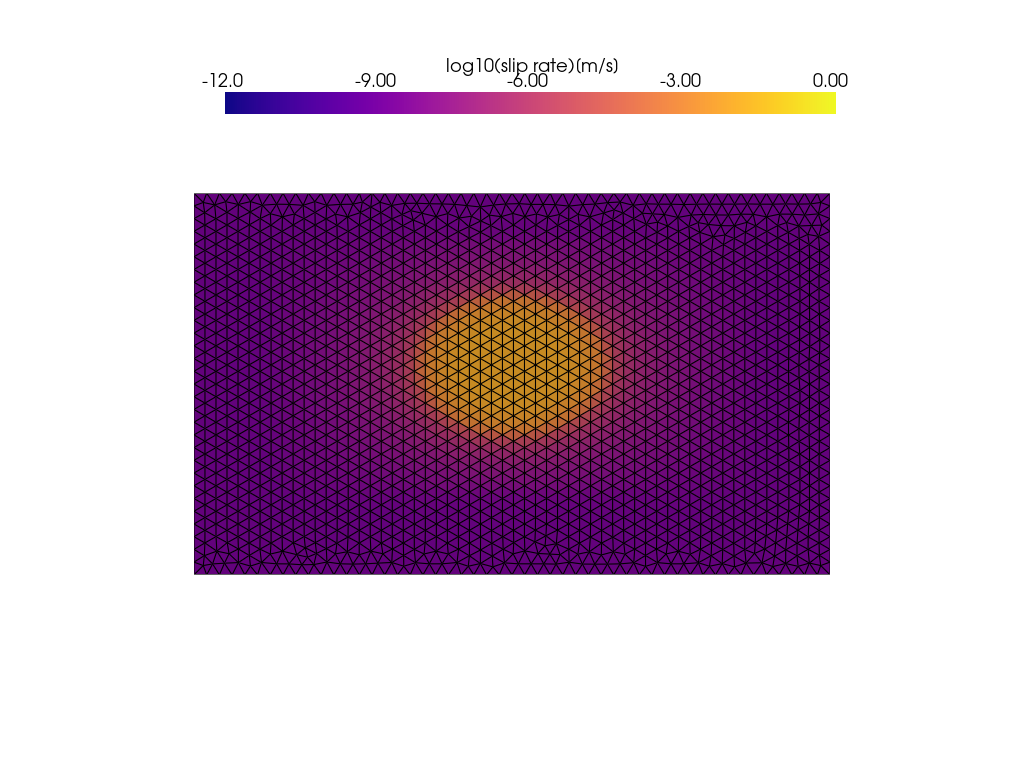

Video has been saved.


In [9]:
import pyvista as pv
import glob
import os

# set vtk file path
folder_path = "outvtk/"  

vtk_files = glob.glob(os.path.join(folder_path, "*.vtk")) + glob.glob(os.path.join(folder_path, "*.vtu"))


#read state file for time show
def is_number(s):
    try:
        float(s) 
        return True
    except ValueError:
        return False

def readstate(fname):
    f=open(fname,'r')
    K=0
    data0=[]
    for line in f:
        tem=line.split()
        
        if(len(tem)==6 and is_number(tem[0])==True):
            data0.append(np.array(tem).astype(float))
    return np.array(data0)
state=readstate('state.txt')
print(state.shape)

# # show one figure 
plotter = pv.Plotter(off_screen=True)
mesh = pv.read(vtk_files[10])
slip_velocity = mesh['Slipv[m/s]']
# Apply logarithmic transformation (e.g., base 10)
# Add small constant (e.g., 1e-10) to avoid log(0) issues
log_slip_velocity = np.log10(slip_velocity)

# Assign the transformed scalars back to the mesh
mesh['Log_Slipv[m/s]'] = log_slip_velocity
scalar_range = (-12, 0)
scalar_bar_args={
        'title': 'log10(slip rate)[m/s]',
        'position_x': 0.22, 
        'position_y': 0.85,  
    }
plotter.add_mesh(mesh, scalars='Log_Slipv[m/s]', cmap="plasma", show_edges=True,clim=scalar_range,scalar_bar_args=scalar_bar_args)  # show shear stress

#plotter.camera_position =[(0, -5, 0), (0, 0, 0), (0, 0, 1)]
# plotter.add_scalar_bar(
#         title='log10(Slip rate)[m/s]',  # Label for the colorbar
#         position_x=0.25,         # Horizontal position (0 to 1, 0.25 centers it with width=0.5)
#         position_y=0.05,         # Vertical position (close to bottom)
#         width=0.5,              # Width of the colorbar (0 to 1, relative to plot)
#         height=0.1,             # Height of the colorbar
#         vertical=False          # Horizontal orientation
#     )
plotter.show(cpos='xz')

# create animation
outsteps=int(sim0.Para0['outsteps'])
plotter = pv.Plotter(off_screen=True)
plotter.open_gif('animation.gif')  # Initialize GIF output

for i, vtk_file in enumerate(vtk_files):
    mesh = pv.read(folder_path+'step'+str(i*outsteps)+'.vtk')
    slip_velocity = mesh['Slipv[m/s]']
    # Apply logarithmic transformation (e.g., base 10)
    # Add small constant (e.g., 1e-10) to avoid log(0) issues
    log_slip_velocity = np.log10(slip_velocity)
    
    # Assign the transformed scalars back to the mesh
    mesh['Log_Slipv[m/s]'] = log_slip_velocity
    plotter.clear()  # Clear previous mesh
    plotter.add_mesh(
        mesh,
        scalars='Log_Slipv[m/s]',
        cmap="plasma",
        show_edges=False,
        clim=scalar_range,
        scalar_bar_args=scalar_bar_args
    )
    
    timeyear=state[i*outsteps,-1]/365
    plotter.add_text(f"Time: {timeyear:.8f} yr", position="upper_left", font_size=14, color="white", shadow=True)
    plotter.camera_position = 'xz'
    plotter.write_frame()  # Write frame to GIF

plotter.close()
print('Video has been saved.')


## GPU acceleration
Install cupy if you want to use GPU acceleration, we recommened to use conda in prompt terminal (e.g. CUDA 11.8):conda install -c conda-forge cupy cudatoolkit=11.8

**Notes**: 
CuPy relies on NVIDIA CUDA for GPU computing, so the following components are required:

1. **NVIDIA GPU Driver**:
Ensure your system has a CUDA-capable NVIDIA GPU (check compatibility at https://developer.nvidia.com/cuda-gpus).
The driver version must support the CUDA Toolkit version used by CuPy (e.g., CUDA 10.2–12.x for CuPy v13.x).

2. **CUDA Toolkit**:
CuPy supports specific CUDA versions (check the latest compatibility at https://docs.cupy.dev/en/stable/install.html).
Common versions: CUDA 11.8 or 12.2 are widely used.





In [12]:
import cupy as cp
print(cp.cuda.is_available())  # check CUDA availble
print(cp.cuda.runtime.getDeviceCount())

True
1


## GPU case

The GPU operates in a similar way to the CPU, only the output is converted to numpy each time. Reading model and parameters is the same as CPU.

**Note**: Make sure to set GPU:True in the parameter.txt

In [10]:

start_time=time.time()
    
totaloutputsteps=int(sim0.Para0['totaloutputsteps'])
directory='outvtk'
if not os.path.exists(directory):
    os.mkdir(directory)

f=open('state.txt','w')
f.write('iteration time_step(s) maximum_slip1_rate(m/s) maximum_slip2_rate(m/s) time(s) time(h)\n')


if(sim0.useGPU==True): #GPU case
    sim0.initGPUvariable()
    
    for i in range(totaloutputsteps):
        print('iteration:',i)
        if(i==0):
            dttry=sim0.htry
        else:
            dttry=dtnext
        dttry,dtnext=sim0.simu_forwardGPU(dttry)

        #transform form cupy to numpy data
        sim0.slipv1=sim0.slipv1_gpu.get()
        sim0.slipv2=sim0.slipv2_gpu.get()
        sim0.slipv=sim0.slipv_gpu.get()
        sim0.slip=sim0.slip_gpu.get()
        sim0.Tt1o=sim0.Tt1o_gpu.get()
        sim0.Tt2o=sim0.Tt2o_gpu.get()
        sim0.Tt=sim0.Tt_gpu.get()
        #sim0.state1=sim0.state1_gpu.get()
        #sim0.state2=sim0.state2_gpu.get()
        sim0.rake=sim0.rake_gpu.get()
        year=sim0.time/3600/24/365
        if(i%10==0):
            print('dt:',dttry,' Seconds:',sim0.time,'  Days:',sim0.time/3600/24,'year',year)
            print(' max_vel1:',np.max(np.abs(sim0.slipv1)),' max_vel2:',np.max(np.abs(sim0.slipv2)),' min_Tt1:',np.min(sim0.Tt1o),' min_Tt2:',np.min(sim0.Tt2o))  
        f.write('%d %f %.16e %.16e %f %f\n' %(i,dttry,np.max(np.abs(sim0.slipv1)),np.max(np.abs(sim0.slipv2)),sim0.time,sim0.time/3600.0/24.0))

        memory_info = process.memory_info()
        print(f"Memory usage: {memory_info.rss / (1024 ** 2)} MB")

        if(sim0.Para0['outputvtk']=='True'):
            outsteps=int(sim0.Para0['outsteps'])#output steps
            if(i%outsteps==0):
                fname=directory+'/step'+str(i)+'.vtk'
                sim0.ouputVTK(fname)



## For MPI version on Linux system

## Step 1: Set Up Conda environment
1. Download latest Miniconda3
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O miniconda.sh

2. Install Miniconda with the following command:
bash miniconda.sh -b -u -p ~/miniconda3

Parameters:

-b: Batch mode, automatically accepts the license agreement.
-u: Updates the installation if the directory already exists.
-p ~/miniconda3: Specifies the installation directory (here, miniconda3 in the home directory).

4. After installation, initialize Conda for terminal use:
~/miniconda3/bin/conda init

5. Close and reopen the terminal, or run:
source ~/.bashrc

6. Verify the Installation,Check the Conda version:
conda --version

7. After installation, create a new environment:
conda create -n PyQuake3D python=3.12

8. Activate the environment:
conda activate PyQuake3D


**Notes**:Dependencies: Ensure wget is installed. If not, install it:
bashsudo apt install wget  # For Ubuntu/Debian
sudo yum install wget  # For CentOS/RHEL

## Step 2: Install Python and C++ Dependencies

**For MPI-CPU verison in Linux (e.g. ubantu)** 
1. Download from https://github.com/Computational-Geophysics/PyQuake3D
2. Install an MPI implementation and g++ compiler(including gcc and other related tools). Common options are:
- sudo apt update
- sudo apt install g++
- sudo apt install openmpi-bin libopenmpi-dev

3. Install PyQuake3D using pip: pip install -r requirements (make sure PyQuake3D environment is activated).
4. Navigate to the src directory, run make to build TDstressFS_C.so.The generated library is called by the Python script Hmatrix.py via dynamic loading (e.g., using ctypes). 

**Notes1**:MPI-CPU version is recommended for use on Linux because it requires compiling a C dynamic library, which used for green's function calculation acceleration. Compiling C dynamic libraries (DLLs) on Windows can be less convenient compared to Linux or other Unix-like systems for several reasons, stemming from differences in tooling, ecosystem, and system design.

**Notes2**:PyQuake3D supports Python 3.8 and above, so there is no need to specify a specific version when installing the library.

## Explore Examples for MPI-based PyQuake3D


To execute benchmarks like BP5-QD, use:
```bash
In the PyQuake3D directory, To run the BP5-QD benchmark:
mpirun -np 10 python src/main_mpi.py -g examples/BP5-QD/bp5t.msh -p examples/BP5-QD/parameter.txt
Ensure you modify the input parameter (`parameter.txt`) as follows:
- `Corefunc directory`: `bp5t_core`
- `InputHetoparamter`: `True`
- `Inputparamter file`: `bp5tparam.dat`

To run the **HF-model**:
mpirun -np 10 python src/main_mpi.py -g examples/HF-model/HFmodel.msh -p examples/HF-model/parameter.txt

To run the  **EAFZ-model**:
mpirun -np 10 python src/main_mpi.py -g examples/EAFZ-model/turkey.msh -p examples/EAFZ-model/parameter.txt

To run the  **Lab-model**:
mpirun -np 10 python src/main_mpi.py -g examples/Lab-model/lab.msh -p examples/Lab-model/parameter.txt


Run these in a Linux terminal.

## Additional Notes

- **Performance:** Use more CPUs (`-np`) or multithreaded parallelism in parameters.
- **Help:** Contact authors at rongjiang@csj.uestc.edu.cn or luca.dalzilio@ntu.edu.sg.
- **Manual:** Refer to the Code Manual PDF for detailed parameter info.

Save this notebook and run cells sequentially. For advanced usage, explore `src/` or modify parameters for custom simulations.